Шаг 1

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv
import os

Шаг 2

In [2]:
# Загрузка переменных окружения
load_dotenv()  
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

# Запросы к API
visit_response = requests.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
registration_response = requests.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")

# Проверка успешности ответа и преобразование в DataFrame
if visit_response.status_code == 200:
    visits = pd.DataFrame(visit_response.json())
    print(visits.head())  
else:
    print("Ошибка при запросе данных о посещениях:", visit_response.status_code)

if registration_response.status_code == 200:
    registrations = pd.DataFrame(registration_response.json())
    print(registrations.head())  
else:
    print("Ошибка при запросе данных о регистрациях:", registration_response.status_code)


current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)



                        datetime platform  \
0  Wed, 01 Mar 2023 10:36:22 GMT      web   
1  Wed, 01 Mar 2023 06:25:00 GMT      web   
2  Wed, 01 Mar 2023 10:26:13 GMT      web   
3  Wed, 01 Mar 2023 12:33:06 GMT      web   
4  Wed, 01 Mar 2023 01:38:35 GMT      web   

                                          user_agent  \
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
1  Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...   
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   

                               visit_id  
0  1de9ea66-70d3-4a1f-8735-df5ef7697fb9  
1  f149f542-e935-4870-9734-6b4501eaf614  
2  08f0ebd4-950c-4dd9-8e97-b5bdf073eed1  
3  19322fed-157c-49c6-b16e-2d5cabeb9592  
4  04762a22-3c9f-40c9-9ac9-6628c4381836  
                        datetime                       email platform  \
0  Wed, 01 Mar 2023 07:40:13 GMT           ebyrd@example.org      w

Проведем предварительный анализ данных о посещениях и регистрации с помощью dataframe.describe:

In [3]:
# Предварительный анализ данных о посещениях
print("Анализ данных о посещениях:")
print(visits.describe())

# Предварительный анализ данных о регистрациях
print("\nАнализ данных о регистрациях:")
print(registrations.describe())


Анализ данных о посещениях:
                             datetime platform  \
count                          263459   263459   
unique                         261204        4   
top     Thu, 06 Jul 2023 10:45:50 GMT      web   
freq                                3   236301   

                                               user_agent  \
count                                              263459   
unique                                                 32   
top     Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...   
freq                                                13623   

                                    visit_id  
count                                 263459  
unique                                146085  
top     64167edd-323a-4ab0-be9b-acd237a1ac30  
freq                                       4  

Анализ данных о регистрациях:
                             datetime               email platform  \
count                           21836               21836    21836   
unique   

Предварительный анализ данных о посещениях показывает, что:

У нас есть 263,459 записей.
Дата и время (datetime) и платформа (platform) имеют одинаковое количество записей, что указывает на полные данные без пропусков.
Самый частый user_agent - это Mozilla/5.0, основанный на Linux.
visit_id также представлен без пропусков, с наиболее частым ID, встречающимся четыре раза.

Предварительный анализ данных о регистрациях показывает, что:

В наборе данных 21,836 записей.
datetime, email, и platform также полные без пропусков.
Самый частый email - ujones@example.com.
Самая частая платформа - android.
registration_type и user_id без пропусков, с самым частым типом регистрации, встречающимся 8,996 раз.

Шаг 3

In [4]:
# Установка параметров отображения для полного просмотра данных в ноутбуке
pd.set_option('display.expand_frame_repr', False)

# Добавление отдельного столбца для даты из timestamp
visits['date'] = pd.to_datetime(visits['datetime']).dt.normalize()
registrations['date'] = pd.to_datetime(registrations['datetime']).dt.normalize()

# Фильтрация данных для учета только последнего визита по каждому ID
visits['latest_visit_time'] = visits.groupby('visit_id')['datetime'].transform('max')
visits = visits[visits['datetime'] == visits['latest_visit_time']]

# Отсеивание визитов от ботов по ключевому слову в User-Agent
visits = visits[~visits['user_agent'].str.contains('bot', case=False, na=False)]

# Агрегирование данных посещений и регистраций по дате и типу платформы
visit_counts = visits.groupby(['date', 'platform']).agg({'visit_id': pd.Series.nunique}).reset_index()
registration_counts = registrations.groupby(['date', 'platform']).agg({'user_id': pd.Series.nunique}).reset_index()

# Слияние агрегированных данных в единый фрейм и обновление названий колонок
consolidated_data = pd.merge(visit_counts, registration_counts, on=['date', 'platform'], how='left')
consolidated_data.columns = ['date_group', 'platform', 'visits', 'registrations']

# Замена пропусков нулевыми значениями в колонке регистраций
consolidated_data['registrations'].fillna(0, inplace=True)

# Вычисление процента конверсии из посещений в регистрации
consolidated_data['conversion'] = (consolidated_data['registrations'] / consolidated_data['visits']) * 100

# Сортировка итогового фрейма данных по дате
consolidated_data.sort_values('date_group', ascending=True, inplace=True)

# Экспорт итоговых данных в JSON-файл
consolidated_data.to_json('conversion.json', orient='records', date_format='epoch')

# Вывод первых нескольких записей для проверки
consolidated_data.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,815,8,0.981595
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


Шаг 4

In [5]:
# Загрузка данных о рекламных кампаниях
ads_data = pd.read_csv('ads.csv')

# Преобразование поля date в datetime
ads_data['date'] = pd.to_datetime(ads_data['date']).dt.normalize()

# Группировка данных по дате и utm_campaign с суммированием затрат
ads_grouped_by_day = ads_data.groupby(['date', 'utm_campaign'], as_index=False).agg({'cost': 'sum'})

# Переименование колонки 'date' в 'date_group'
ads_grouped_by_day = ads_grouped_by_day.rename(columns={'date': 'date_group'})

# Проверяем, что у нас есть
print(ads_grouped_by_day.head())


  date_group                utm_campaign  cost
0 2023-03-01  advanced_algorithms_series   212
1 2023-03-02  advanced_algorithms_series   252
2 2023-03-03  advanced_algorithms_series   202
3 2023-03-04  advanced_algorithms_series   223
4 2023-03-05  advanced_algorithms_series   265


In [6]:
# Объединяем с датафреймом конверсий, который мы уже создали ранее
consolidated_data['date_group'] = pd.to_datetime(consolidated_data['date_group'])
final_ads_df = pd.merge(consolidated_data, ads_grouped_by_day, left_on='date_group', right_on='date_group', how='left')

# Заполняем нулями пропущенные значения затрат и ставим 'none' для кампаний, если данные отсутствуют
final_ads_df['cost'].fillna(0, inplace=True)
final_ads_df['utm_campaign'].fillna('none', inplace=True)

# Оставляем необходимые колонки и переименовываем их для соответствия требованиям
final_ads_df = final_ads_df[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

# Сортировка по дате
final_ads_df.sort_values(by='date_group', inplace=True)

# Проверяем итоговый датафрейм
print(final_ads_df.head())

# Сохранение итогового датафрейма в формате JSON
final_ads_df.to_json('ads.json', orient='records', date_format='iso')

  date_group  visits  registrations   cost                utm_campaign
0 2023-03-01      75             61  212.0  advanced_algorithms_series
1 2023-03-01      22             18  212.0  advanced_algorithms_series
2 2023-03-01     815              8  212.0  advanced_algorithms_series
3 2023-03-02      67             59  252.0  advanced_algorithms_series
4 2023-03-02      31             24  252.0  advanced_algorithms_series


Шаг 5

Итоговые визиты

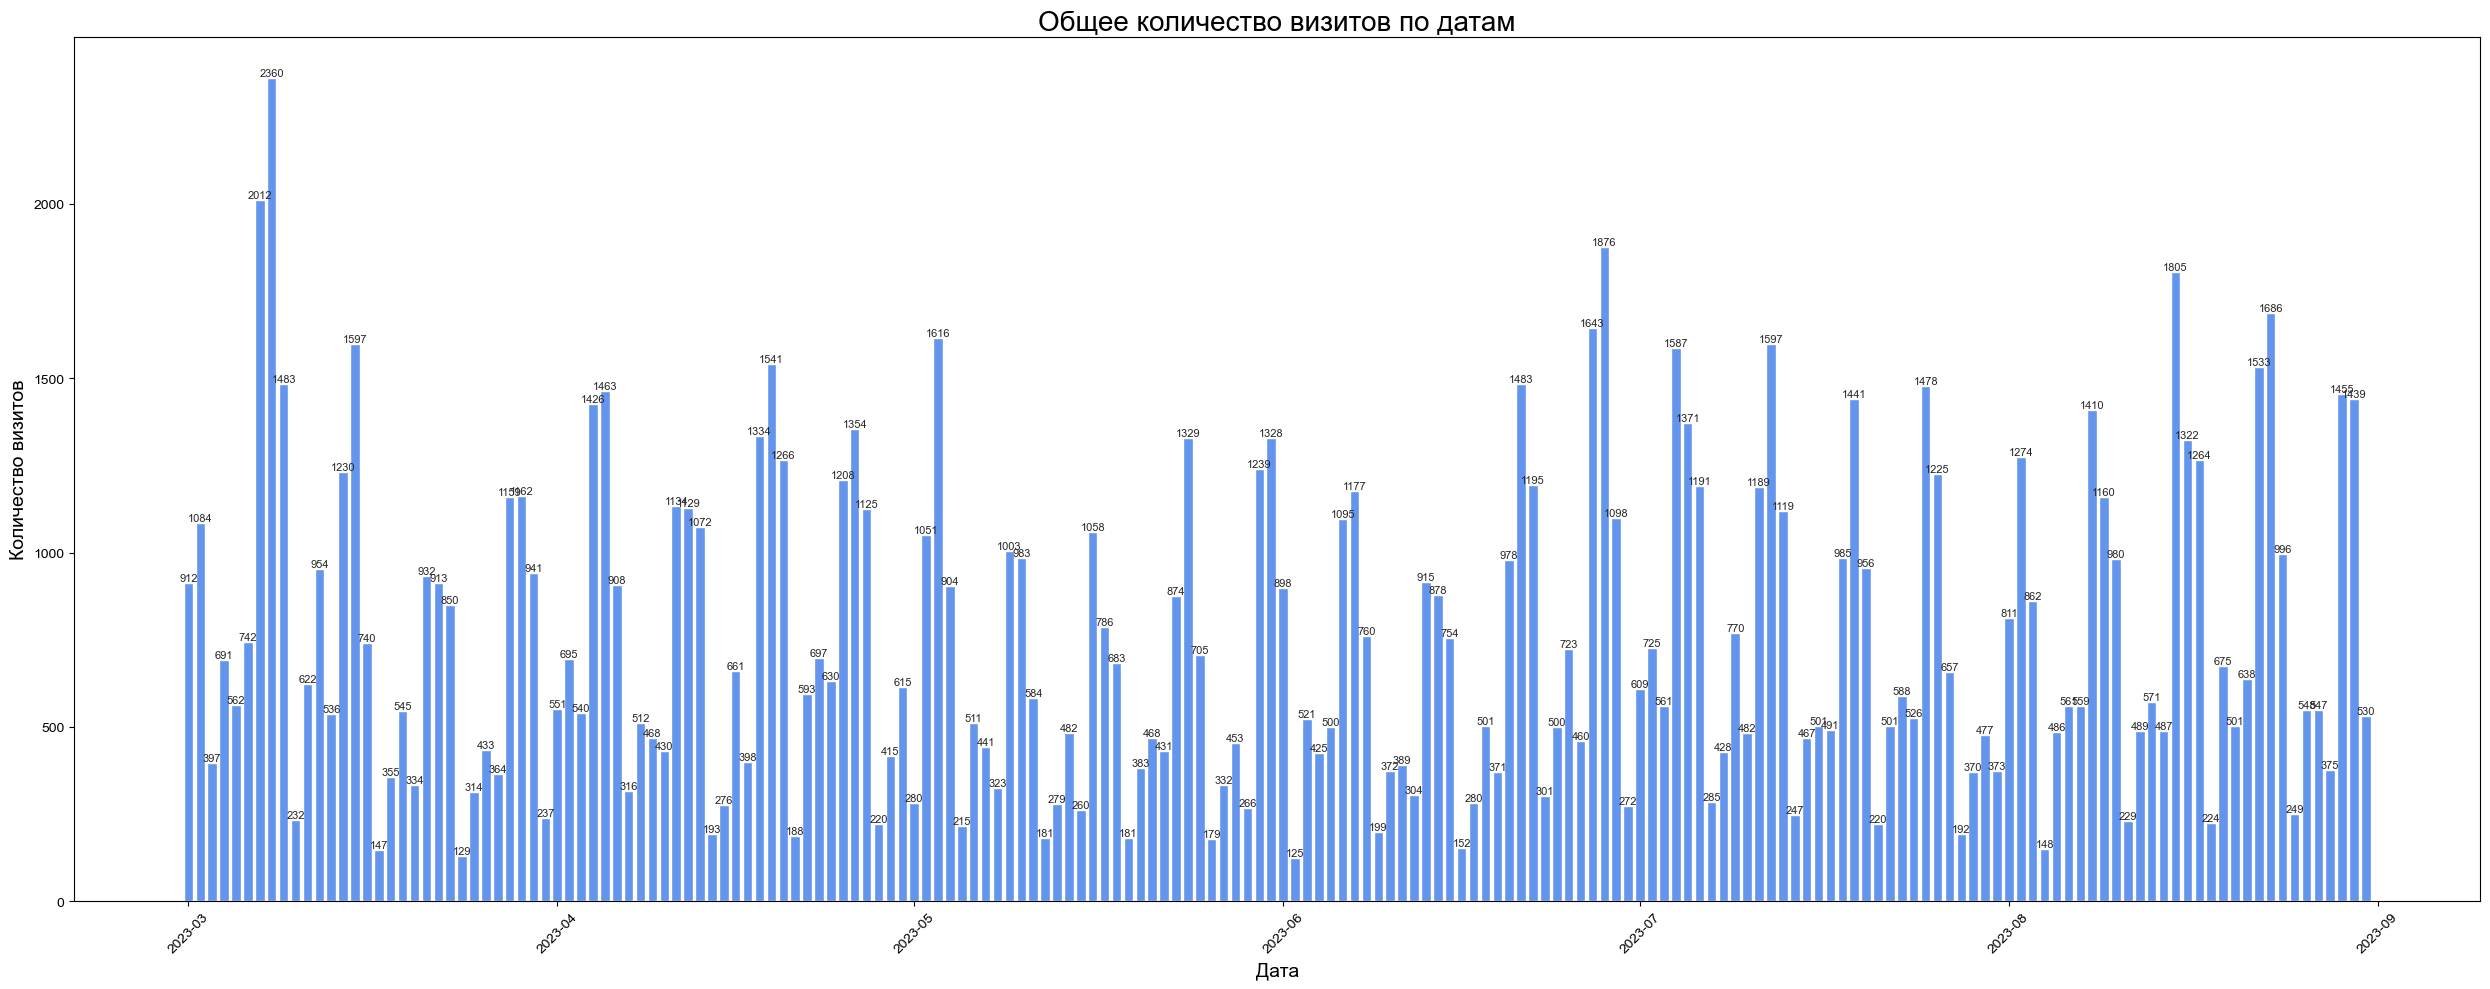

In [7]:
# Создаем визуализацию суммарного количества визитов
total_visits = final_ads_df.groupby('date_group')['visits'].sum().reset_index()

# Настраиваем размер изображения и стиль фона
fig, ax = plt.subplots(figsize=(25, 10))
sns.set_style("white")

# Строим столбчатый график с выбором цвета
plt.bar(total_visits['date_group'], total_visits['visits'], color='cornflowerblue')

# Добавляем подписи к столбцам графика для удобства интерпретации данных
ax.bar_label(ax.containers[0], fontsize=8)

# Устанавливаем параметры визуального отображения осей графика
plt.xticks(rotation=45, fontsize=10)  
plt.yticks(fontsize=10)  

# Настраиваем названия осей и заголовок графика
plt.title('Общее количество визитов по датам', fontsize=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество визитов', fontsize=14)

# Сохраняем график в файл
plt.tight_layout()  # Для корректного сохранения изображения
plt.savefig("charts/Total_Visits.png")

# Отображаем график
plt.show()

Итоговые визиты с разбивкой по платформам

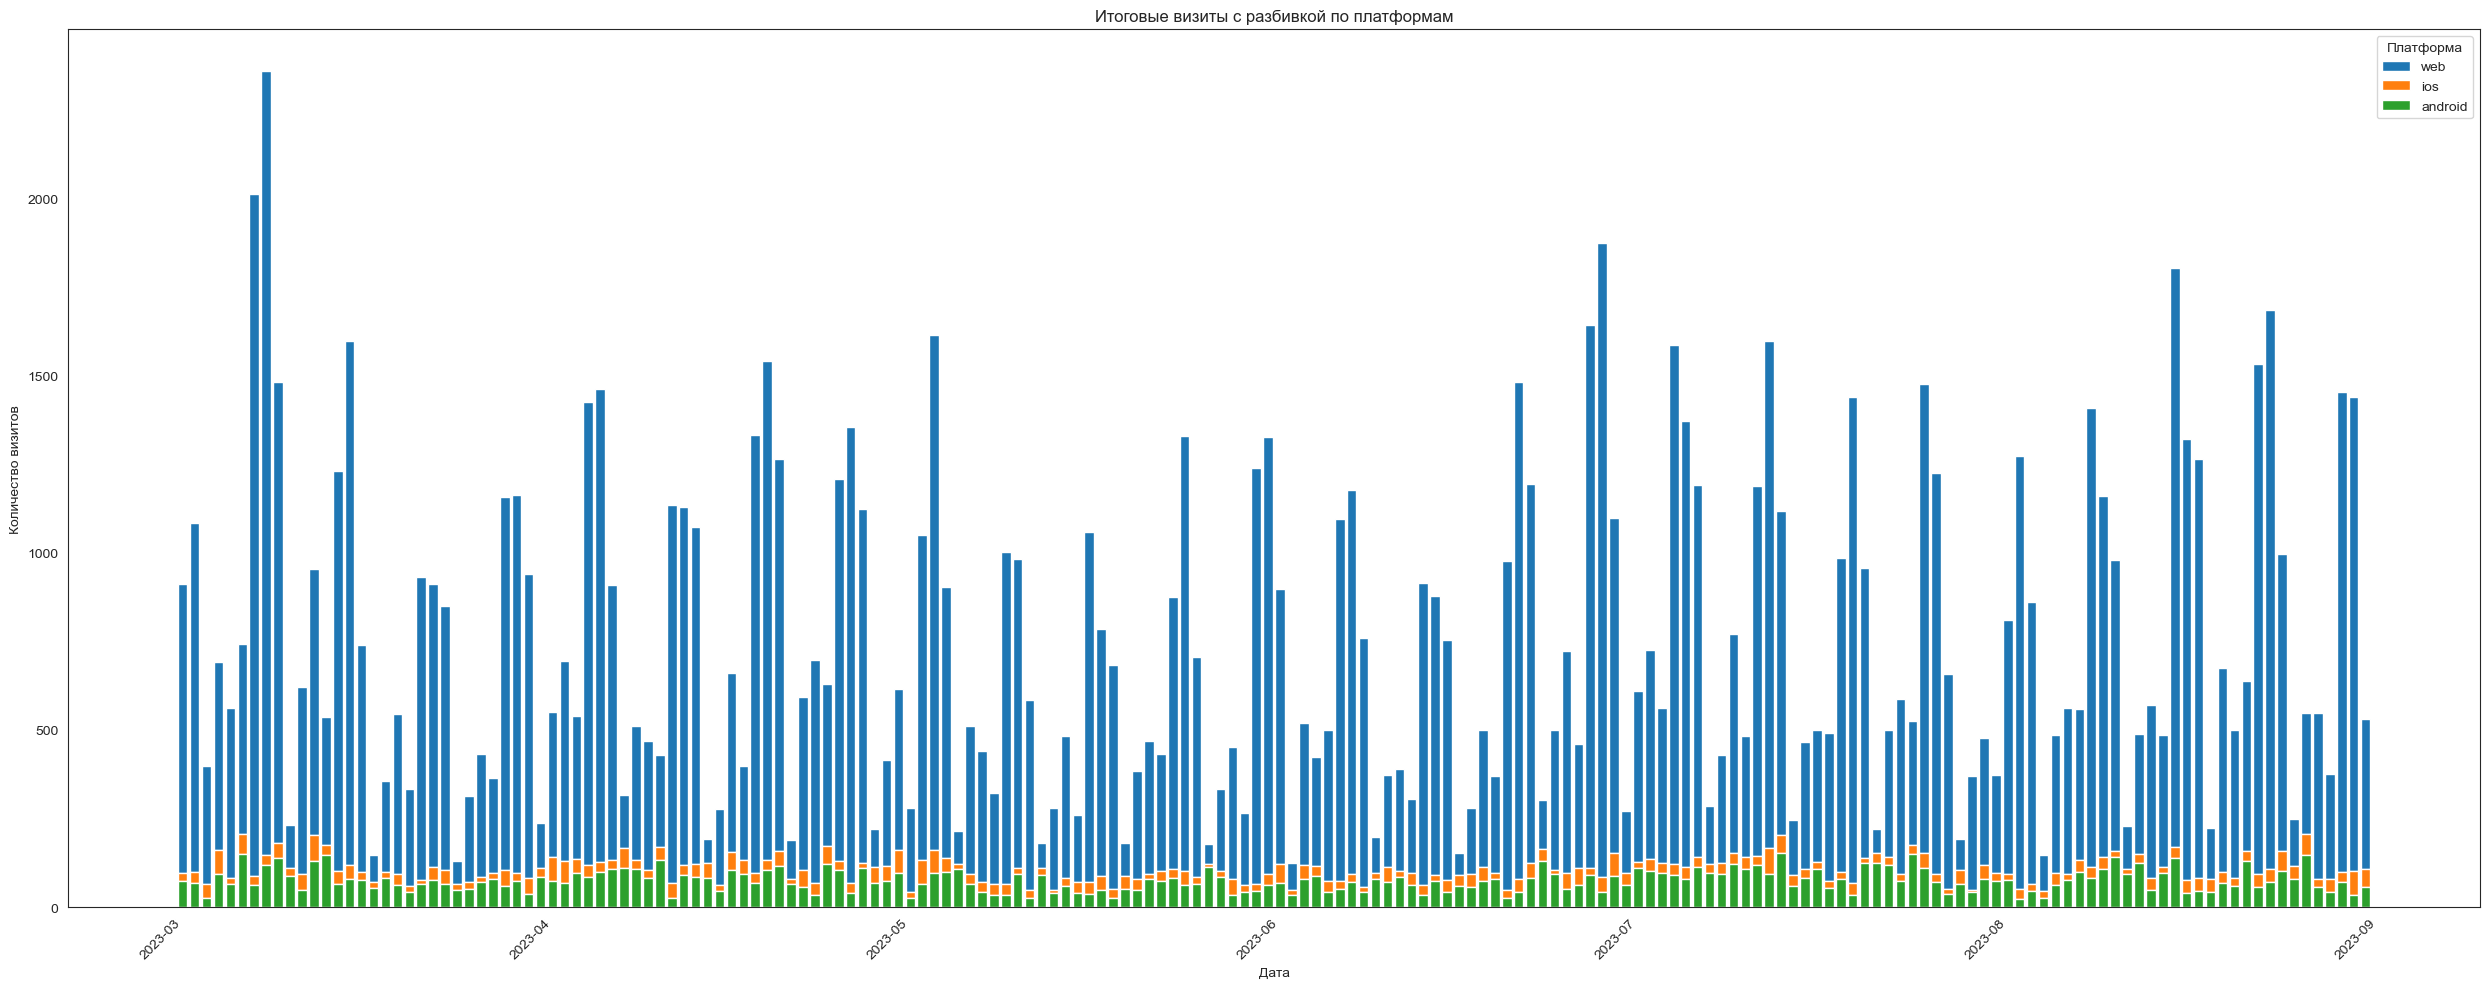

In [8]:
grouped = consolidated_data.groupby(['date_group', 'platform'])['visits'].sum().unstack(fill_value=0)

# Вычисляем кумулятивную сумму по колонкам, что необходимо для отображения накопленных значений на графике.
grouped_cumulative = grouped.cumsum(axis=1)

# Подготавливаем фигуру и оси для визуализации данных.
fig, ax = plt.subplots(figsize=(25, 10))

# Строим накопленные столбцы для каждой платформы, где каждый столбец будет представлять собой сумму визитов 
# за каждую дату, сложенную поверх предыдущих значений других платформ.
for platform in grouped.columns[::-1]:  
    ax.bar(grouped.index, grouped[platform], bottom=grouped_cumulative[platform] - grouped[platform], label=platform)

# Устанавливаем стиль сетки для лучшей читаемости графика и задаем параметры отображения меток осей.
sns.set_style("whitegrid")
plt.xticks(rotation=45, ha='right')  
plt.xlabel('Дата')  
plt.ylabel('Количество визитов')  
plt.title('Итоговые визиты с разбивкой по платформам')  

# Добавляем легенду, чтобы обозначить цвета, соответствующие каждой платформе.
plt.legend(title='Платформа')

# Сохраняем итоговый график в файл, предварительно убедившись, что все элементы графика поместятся на изображении.
plt.tight_layout()
plt.savefig('charts/Visits by Platform (Stacked).png')

# Показываем график.
plt.show()

Итоговые регистрации по неделям

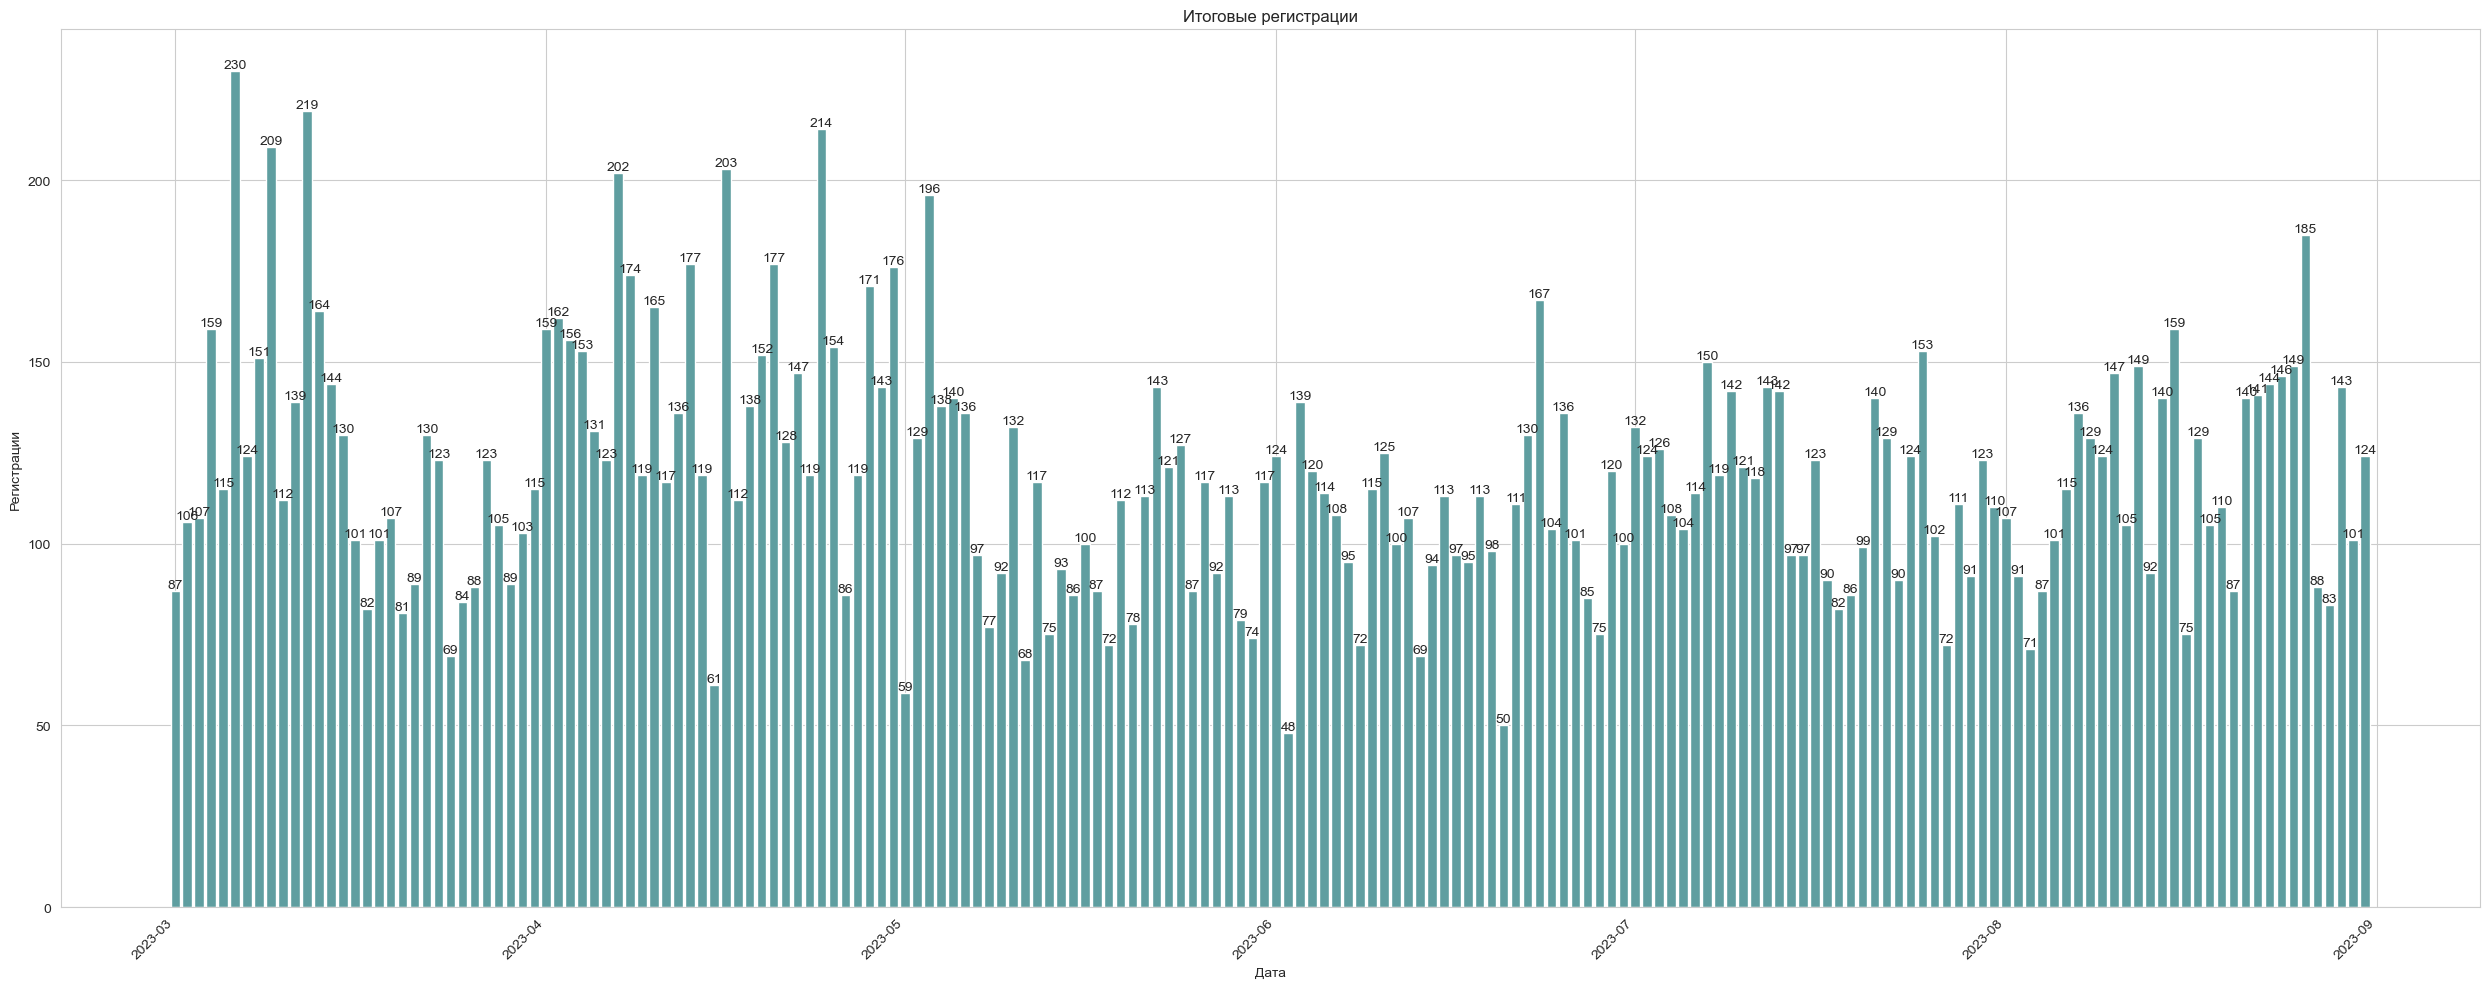

In [9]:
# Группируем данные по дате, считаем суммарное количество регистраций для каждой даты.
total_registrations = consolidated_data.groupby('date_group')['registrations'].sum().reset_index()

# Создаем визуализацию для итогового количества регистраций
fig, ax = plt.subplots(figsize=(25, 10))
# Строим столбчатый график, используя цветовую схему Seaborn
plt.bar(total_registrations['date_group'], total_registrations['registrations'], color='cadetblue')

# Добавляем подписи к столбцам для удобства чтения значений
ax.bar_label(ax.containers[0], fontsize=10)

# Устанавливаем параметры визуального отображения осей
sns.set_style("whitegrid")
plt.xticks(rotation=45, ha='right')  
plt.xlabel('Дата')  
plt.ylabel('Регистрации')  
plt.title('Итоговые регистрации') 

# Сохраняем и отображаем график
plt.tight_layout()
plt.savefig('charts/Total Weekly registrations.png')
plt.show()

Итоговые регистрации по платформам

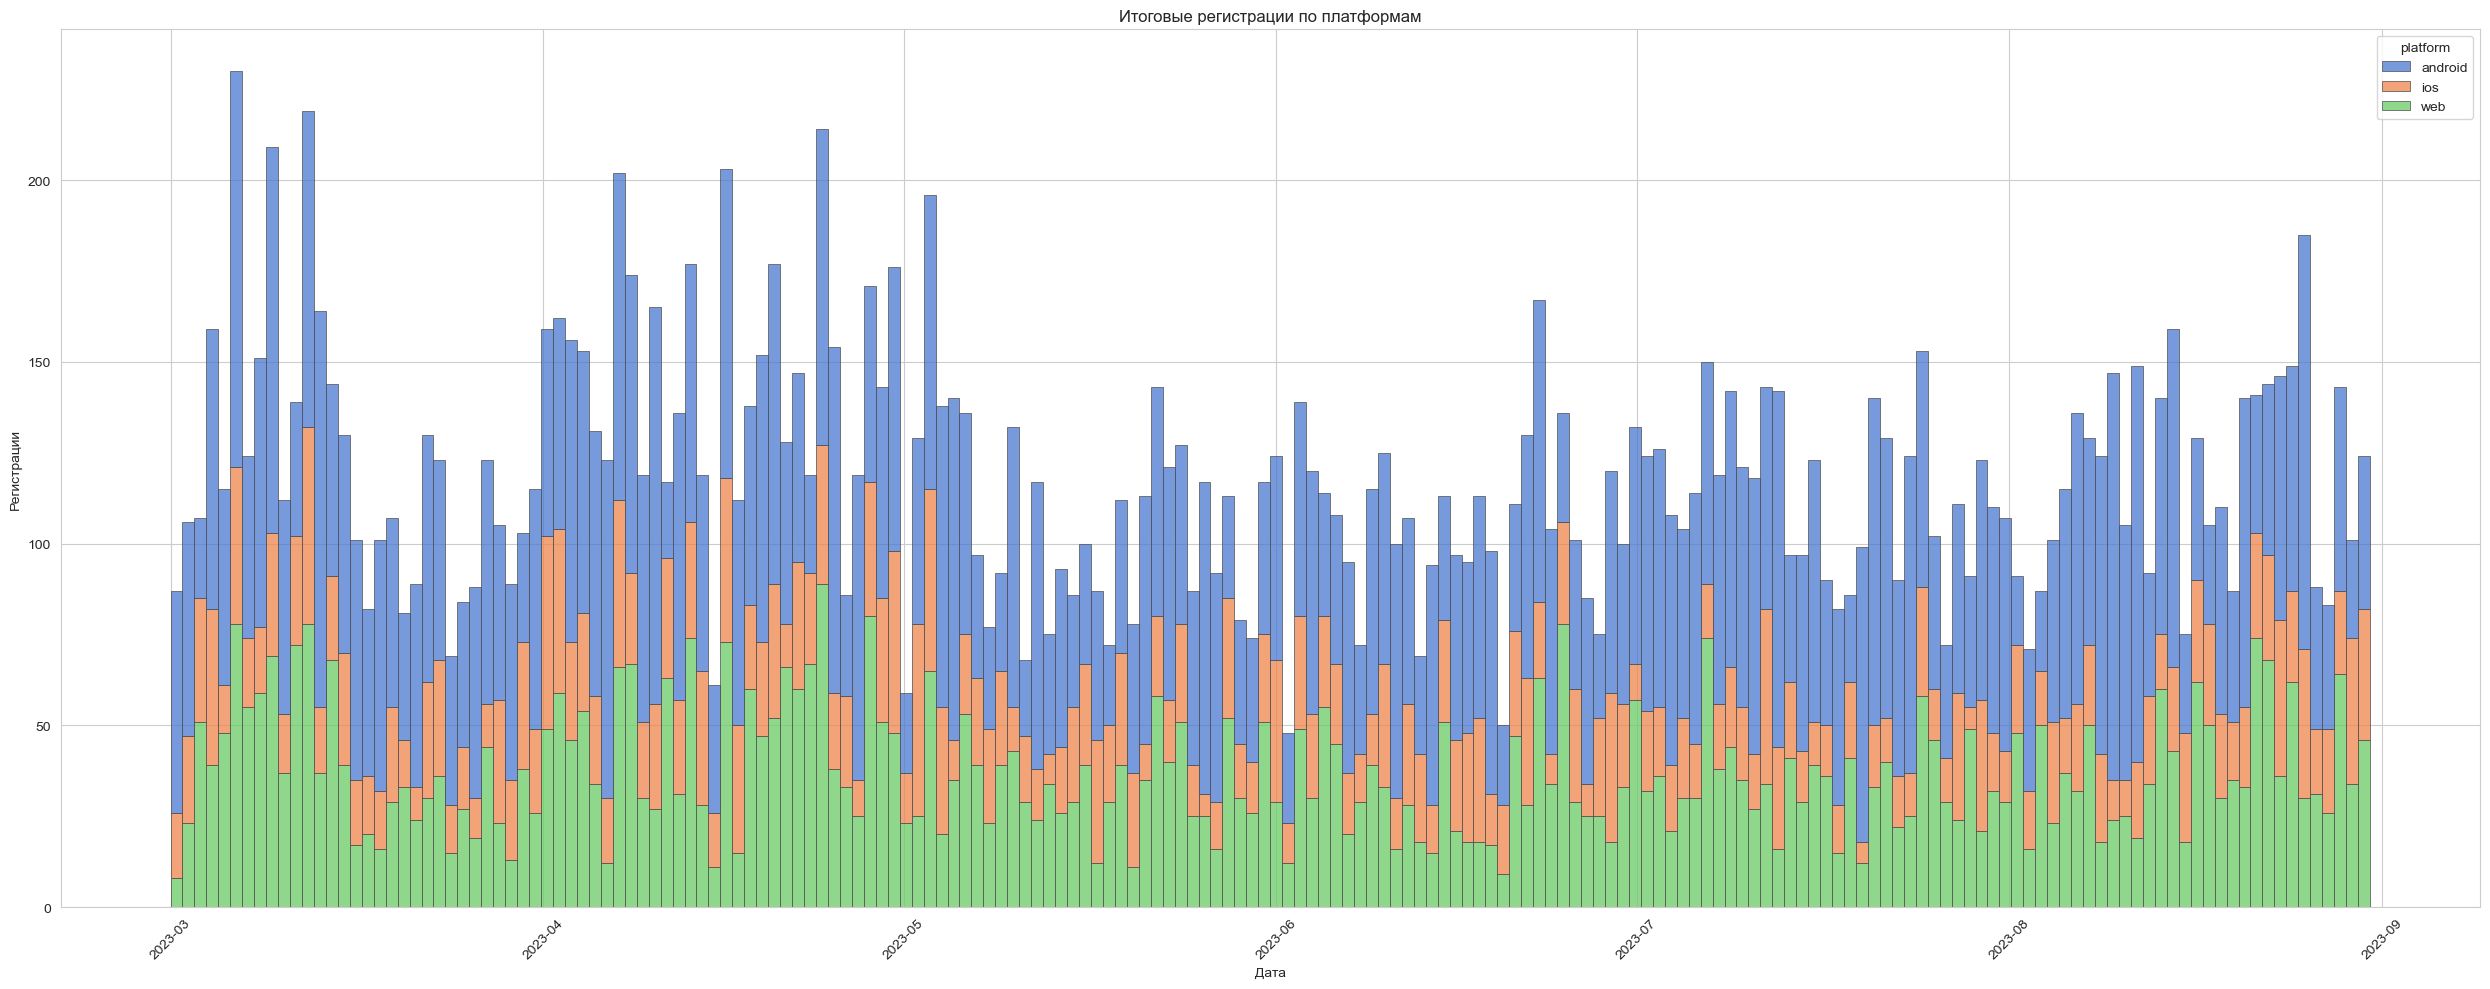

In [10]:
# Группировка данных регистраций по дате и типу платформы
grouped_registrations = consolidated_data.groupby(['date_group', 'platform'])['registrations'].sum().reset_index()

# Создание фигуры и осей для визуализации
fig, ax = plt.subplots(figsize=(25, 10))

# Построение гистограммы с накоплением
sns.histplot(
    data=grouped_registrations, 
    x='date_group', 
    weights='registrations', 
    hue='platform', 
    multiple='stack',
    palette='muted',
    bins=len(grouped_registrations['date_group'].unique()),  
    edgecolor='.3',
    linewidth=.5
)

# Настройка стилей и меток
sns.set_style("whitegrid")
plt.xticks(rotation=45)  
plt.xlabel('Дата')  
plt.ylabel('Регистрации')  
plt.title('Итоговые регистрации по платформам')  

# Проверка и добавление легенды
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(handles=handles, title='Платформа')

# Сохранение изображения графика в файл
plt.tight_layout()  
plt.savefig('charts/Total_Registrations_by_Platform_Stacked.png')

# Отображение графика
plt.show()

Итоговые конверсии

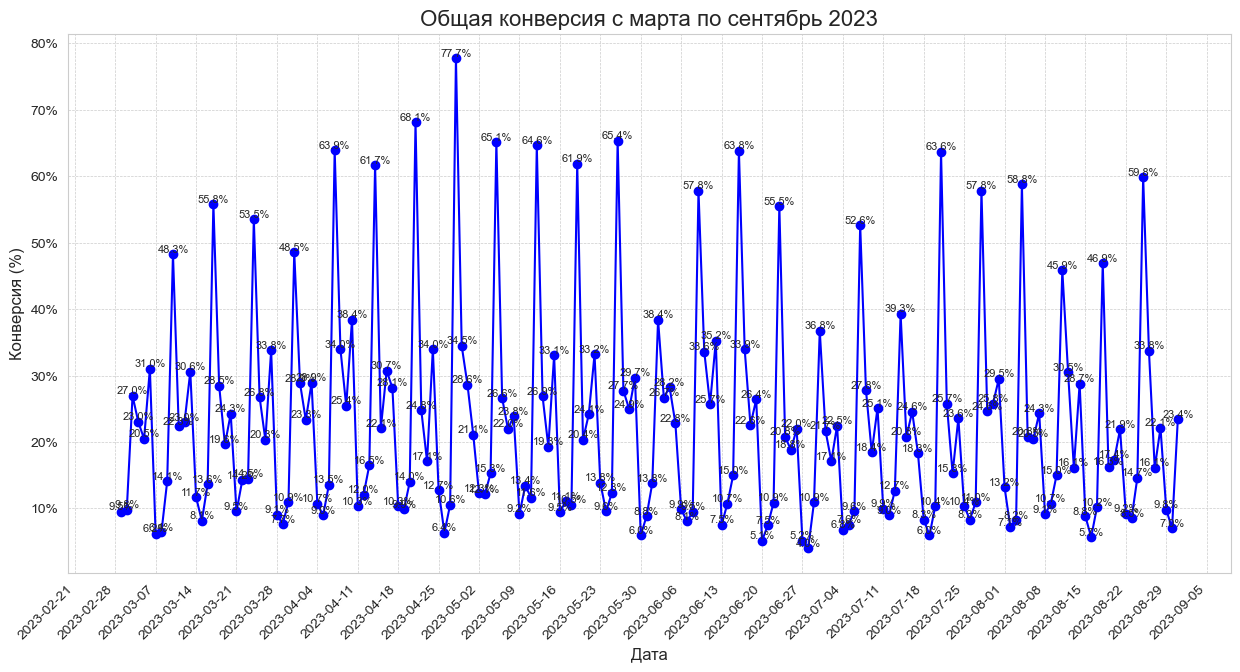

In [11]:
# Преобразование столбца 'date_group' в формат datetime для удобства работы с датами
final_ads_df['date_group'] = pd.to_datetime(final_ads_df['date_group'])

# Фильтрация данных для включения только дат между мартом и сентябрем 2023 года
final_ads_df = final_ads_df[(final_ads_df['date_group'] >= '2023-03-01') & (final_ads_df['date_group'] <= '2023-09-30')]

# Группировка данных по 'date_group' и подсчет суммарного количества посещений и регистраций
visits_per_day = final_ads_df.groupby('date_group').agg({'visits': 'sum'})
registrations_per_day = final_ads_df.groupby('date_group').agg({'registrations': 'sum'})

# Расчет общей конверсии как отношение количества регистраций к посещениям, умноженное на 100
total_conversion = (registrations_per_day['registrations'] / visits_per_day['visits'] * 100).reset_index()
total_conversion = total_conversion.rename(columns={0: 'conversion'})

# Построение графика общей конверсии
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(total_conversion['date_group'], total_conversion['conversion'],
        marker='o', linestyle='-', color='blue')

# Установка форматтера для оси Y в процентах
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Добавление подписей к точкам на графике
for x, y in zip(total_conversion['date_group'], total_conversion['conversion']):
    ax.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=8)

# Настройка внешнего вида графика: заголовок, подписи осей, сетка
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Конверсия (%)', fontsize=12)
ax.set_title('Общая конверсия с марта по сентябрь 2023', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.savefig('charts/Overall Conversion.png')
# Показываем график
plt.show()


Конверсия по каждой платформе

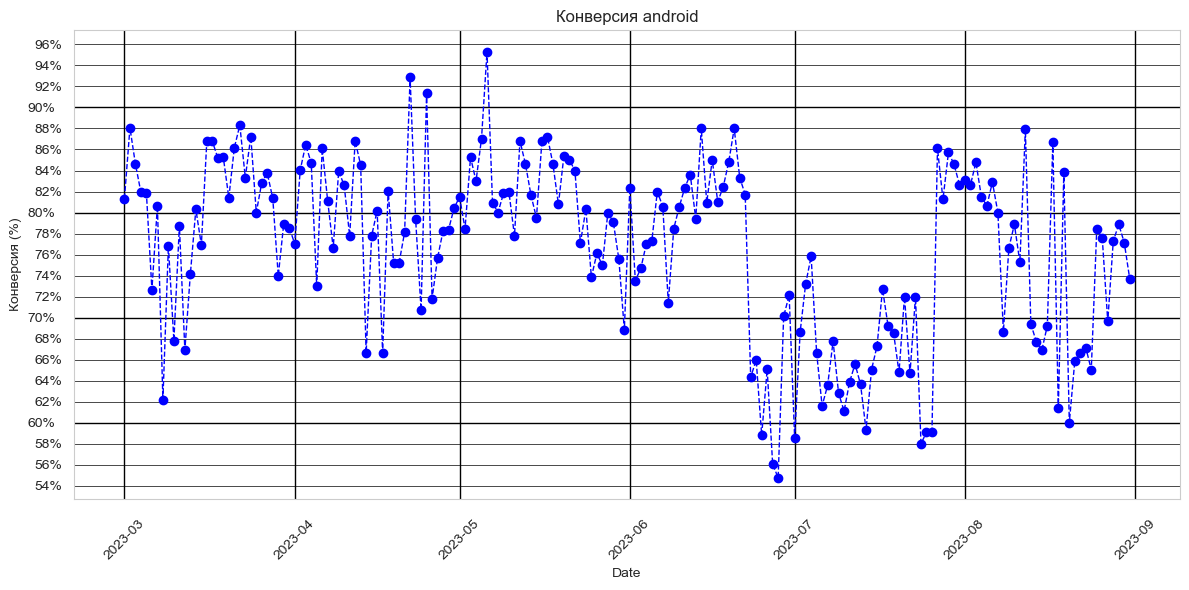

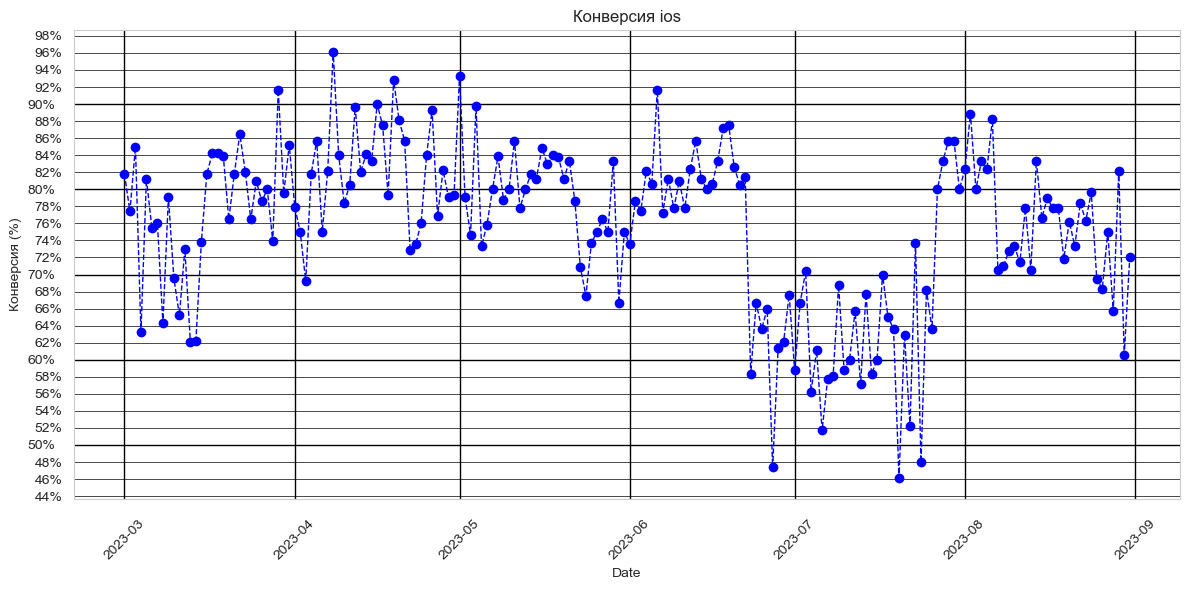

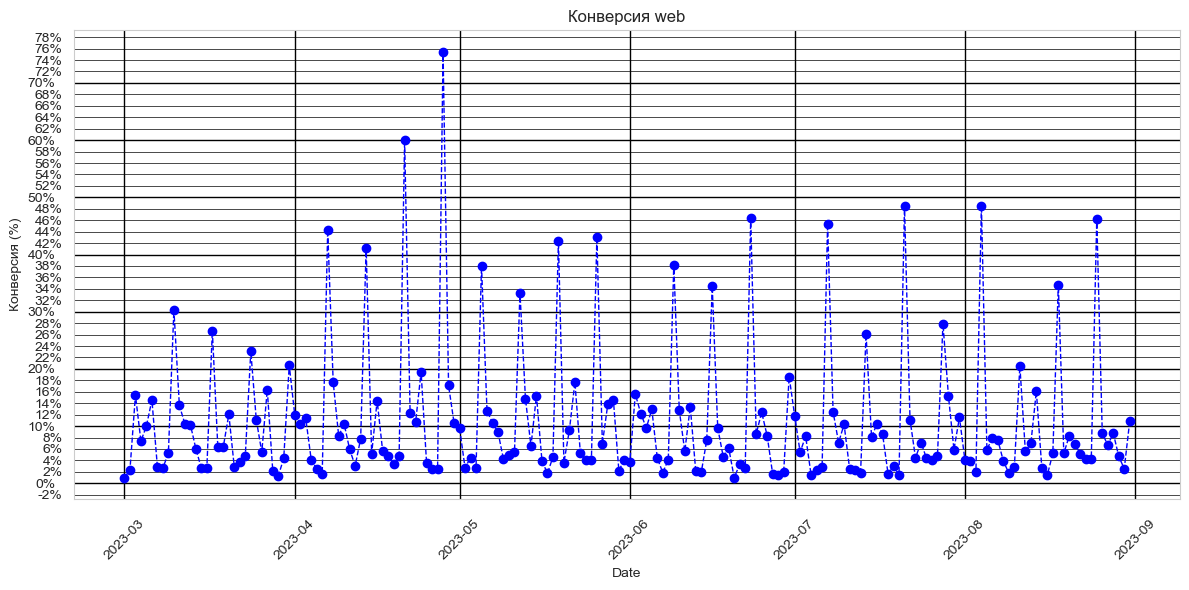

In [12]:
# Конвертация 'date_group' из формата времени эпохи в удобочитаемый формат даты
consolidated_data['date_group'] = pd.to_datetime(consolidated_data['date_group'], unit='ms')

def platform_conversion(consolidated_data, platform):
    # Фильтрация данных по платформе
    consolidated_data_platform = consolidated_data[consolidated_data['platform'] == platform]

    # Создание фигуры для графика 
    fig, ax = plt.subplots(figsize=(12, 6))
    # Построение графика конверсии: дата на оси X и конверсия на оси Y
    ax.plot(consolidated_data_platform['date_group'], consolidated_data_platform['conversion'],
            color='blue', 
            marker='o',
            linestyle='dashed', 
            linewidth=1, 
            markersize=6) 
    ax.grid() 
    ax.set_xlabel('Date') 
    ax.set_ylabel('Конверсия (%)') 
    plt.title(f'Конверсия {platform}') 
    plt.xticks(rotation=45) 
    plt.grid()
   
    # Настройка основных и дополнительных делений на оси Y
    ax.yaxis.set_major_locator(MultipleLocator(10)) 
    ax.yaxis.set_major_formatter('{x:.0f}%') 

    ax.yaxis.set_minor_locator(MultipleLocator(2)) 
    ax.yaxis.set_minor_formatter('{x:.0f}%') 

    # Настройка стиля сетки
    ax.grid(which='major', color='black', linewidth=1) 
    ax.grid(which='minor', color='black', linewidth=0.5) 

    # Настройка внешнего вида делений на осях
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=5)

    plt.tight_layout() 
    plt.savefig(f"charts/Conversion {platform}.png")
    plt.show() 

# Построение графика конверсии для каждой платформы
for platform in consolidated_data['platform'].unique():
    platform_conversion(consolidated_data, platform)

Стоимости реклам

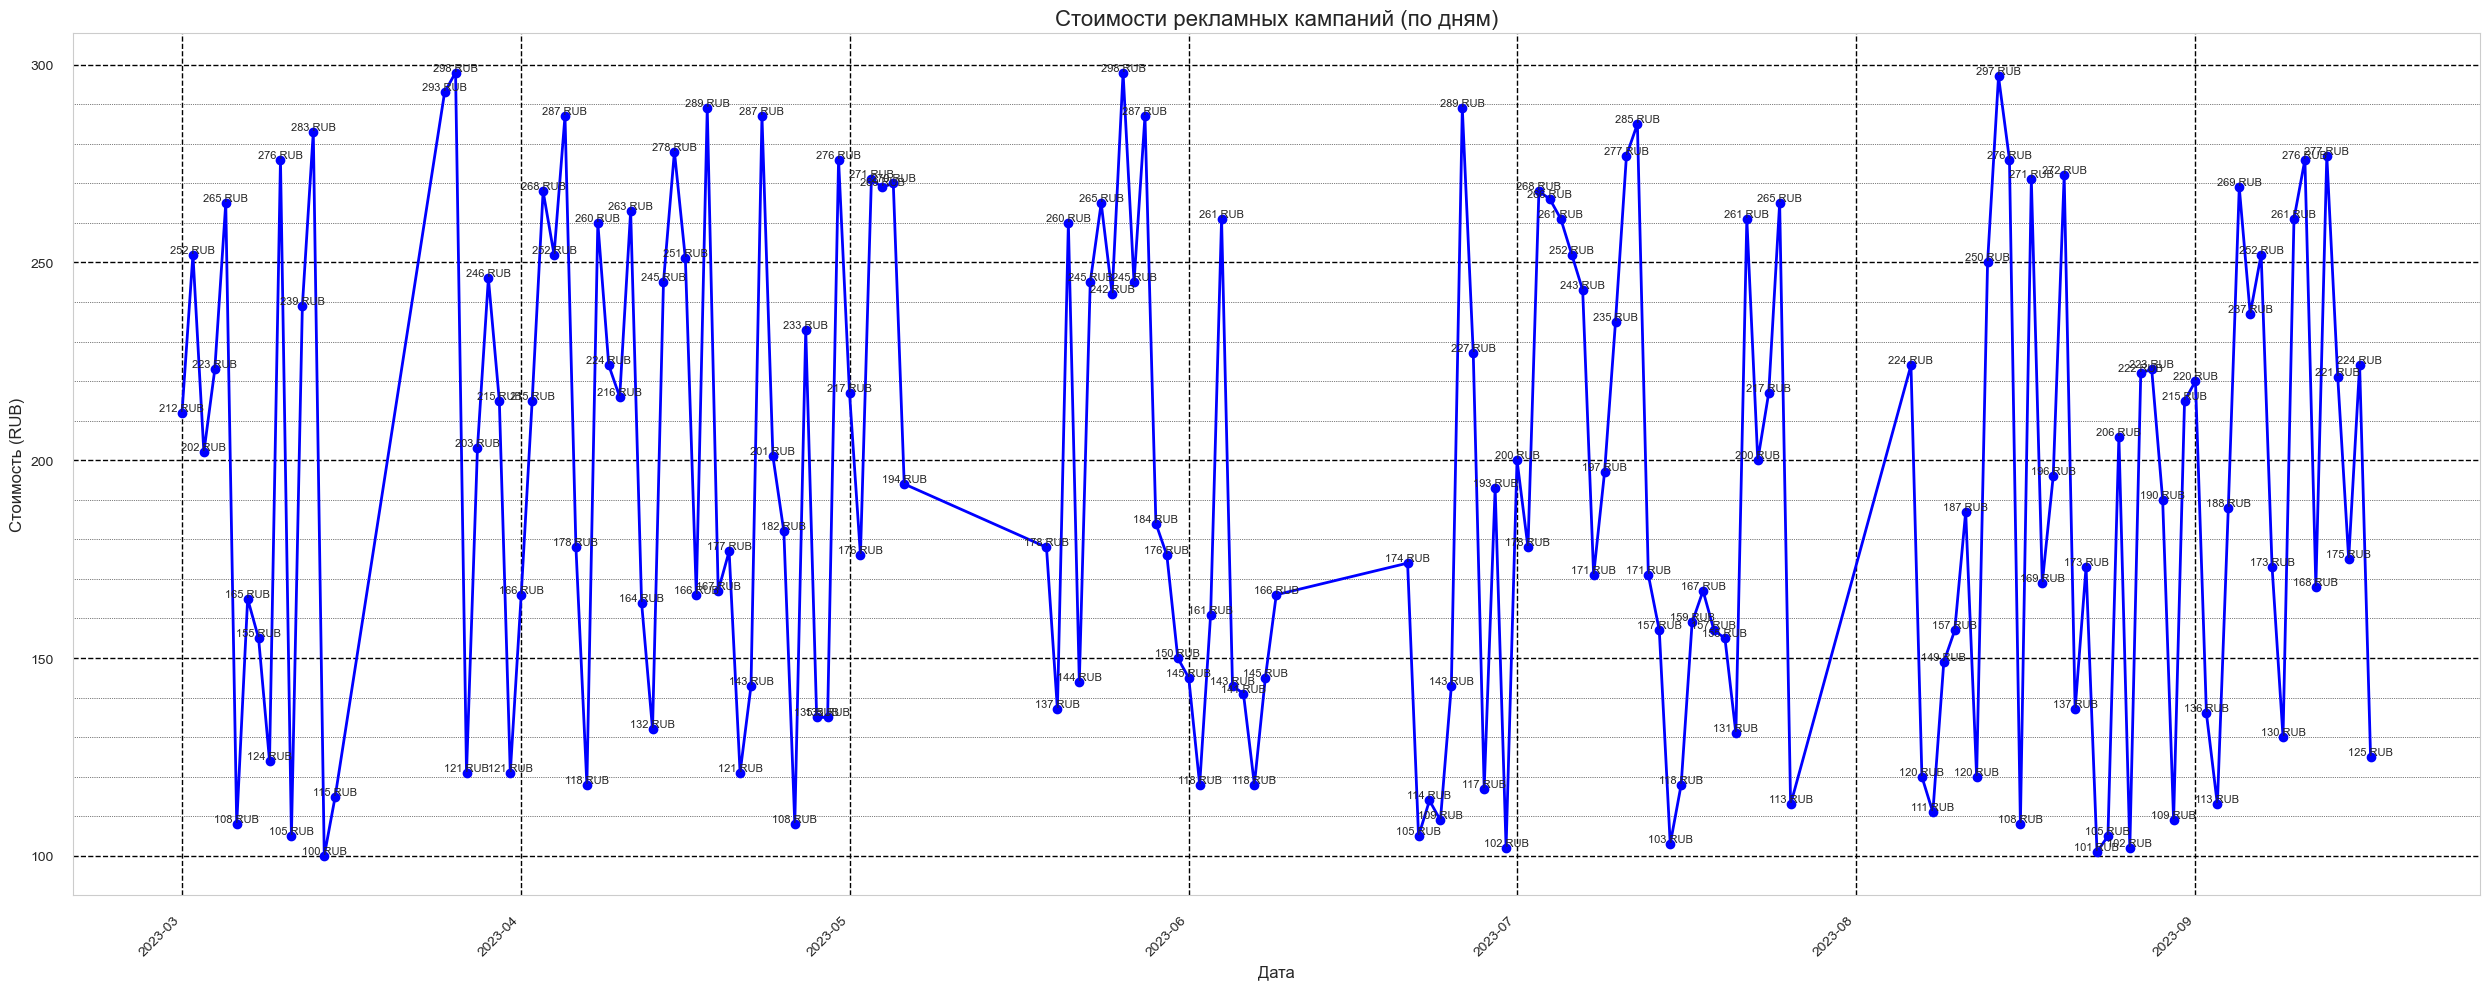

In [13]:
# Построение графика стоимости рекламных кампаний с указанием стоимости сверху
plt.figure(figsize=(25, 10))  # Задаем размер графика

# Строим линейный график стоимости
plt.plot(ads_grouped_by_day['date_group'], ads_grouped_by_day['cost'],
         color='blue',  
         marker='o',  
         linestyle='-',  
         linewidth=2,  
         markersize=6)  

# Добавляем аннотации с затратами над каждой точкой
for i, (date, cost) in enumerate(zip(ads_grouped_by_day['date_group'], ads_grouped_by_day['cost'])):
    plt.text(date, cost, f'{cost} RUB', ha='center', va='bottom', fontsize=8)

# Добавляем сетку, метки осей и заголовок
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость (RUB)', fontsize=12)
plt.title('Стоимости рекламных кампаний (по дням)', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Поворот меток дат на оси X

# Настраиваем отображение тиков и сетки на оси Y
plt.gca().yaxis.set_major_locator(MultipleLocator(50))  
plt.gca().yaxis.set_minor_locator(MultipleLocator(10))  
plt.gca().grid(which='major', color='black', linewidth=1)  
plt.gca().grid(which='minor', color='black', linestyle=':', linewidth=0.5)  
plt.gca().tick_params(which='major', length=10)  
plt.gca().tick_params(which='minor', length=4)  

# Показываем и сохраняем график 
plt.tight_layout()
plt.savefig('charts/Aggregated Ad Campaign Costs (by day).png')
plt.show()

Визиты за весь период с цветовым выделением рекламной кампании

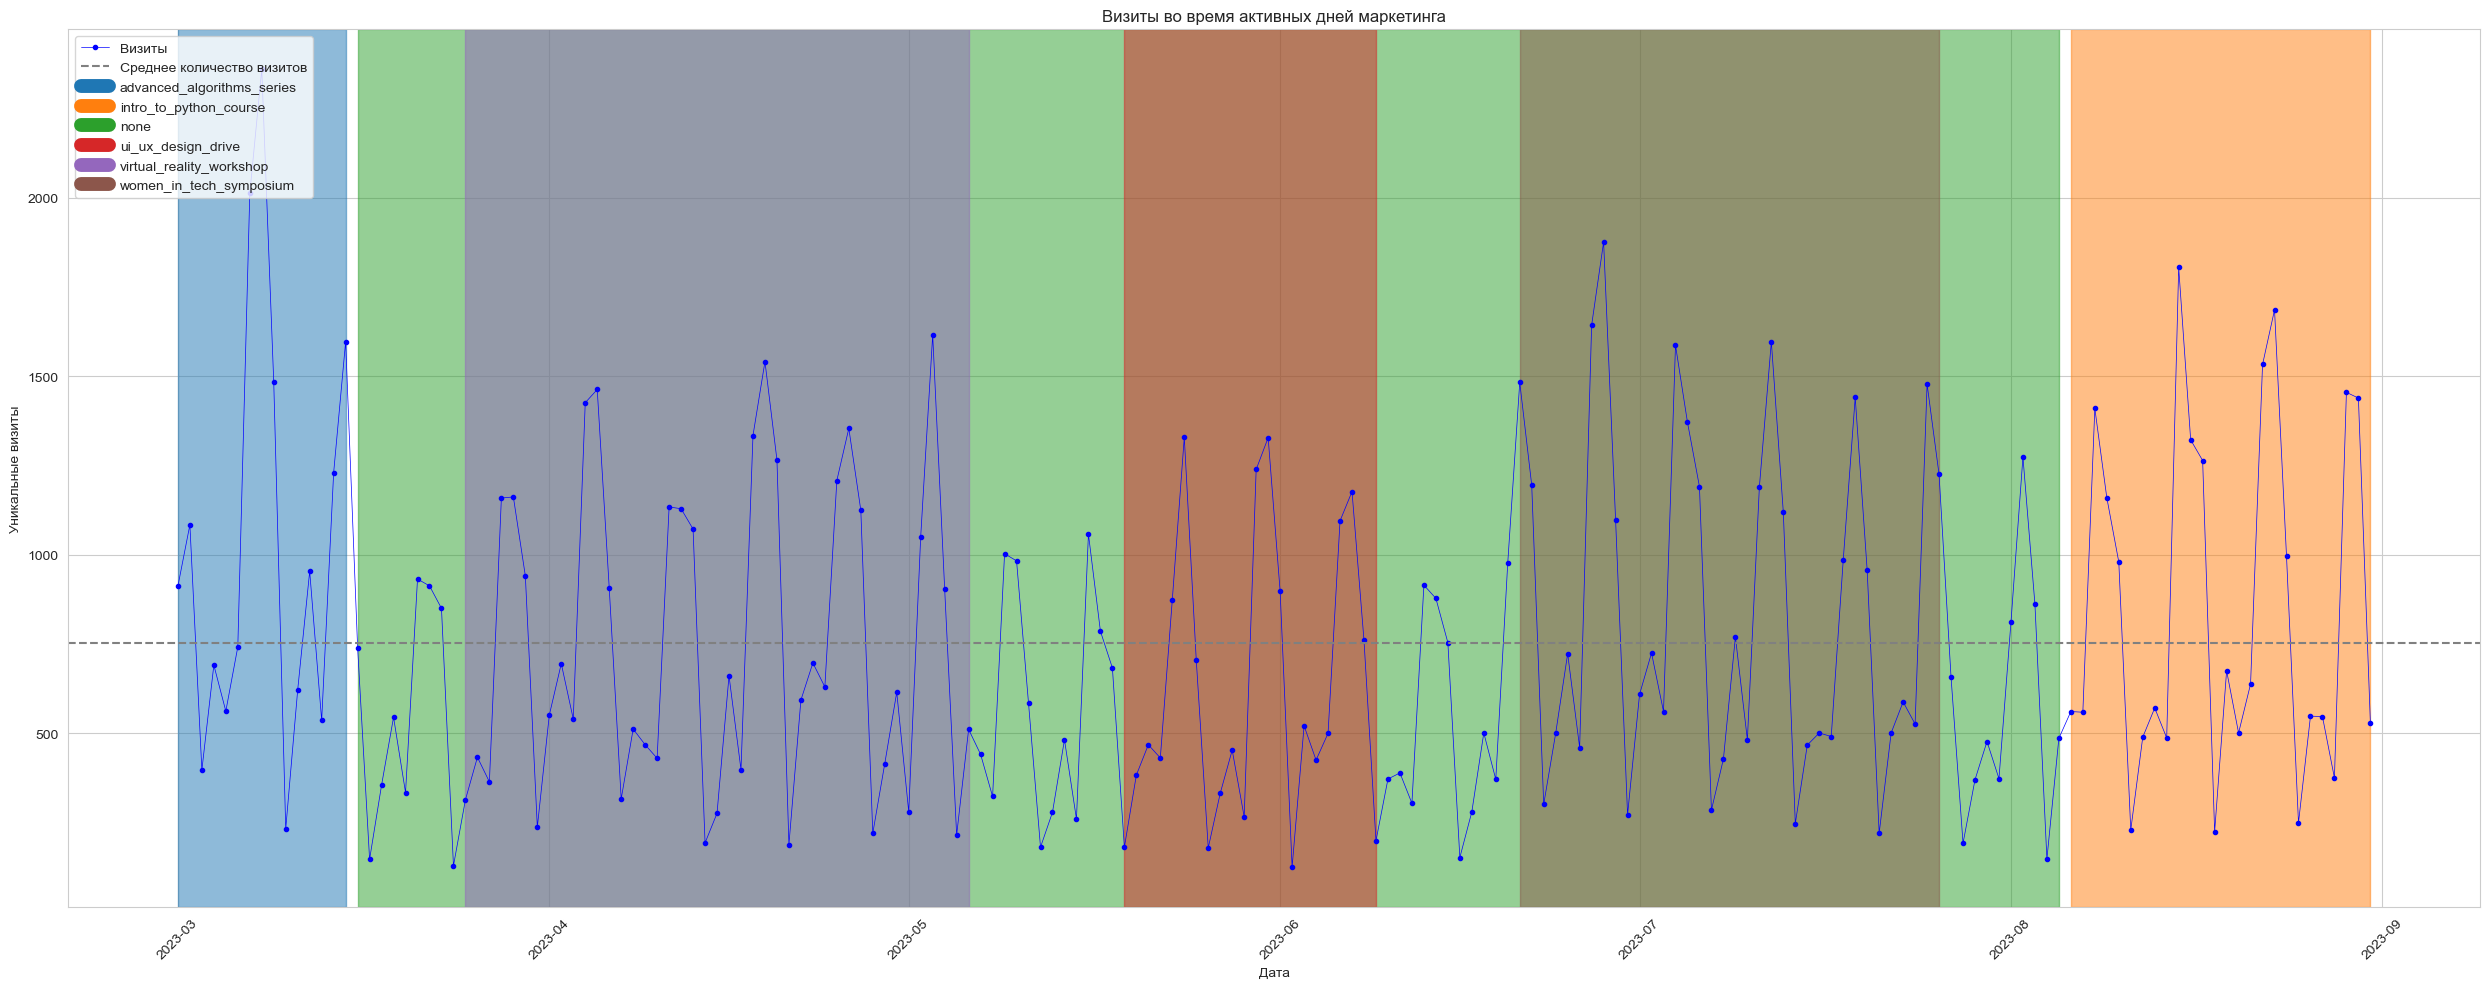

In [14]:
visits_from_utm_campaign = final_ads_df.groupby(['date_group', 'utm_campaign']).agg({'visits':'sum'}).reset_index()
ads_periods = visits_from_utm_campaign[['utm_campaign', 'date_group']].groupby('utm_campaign').apply(lambda x : x.loc[(x['date_group'] == x['date_group'].min()) | (x['date_group'] == x['date_group'].max())]).reset_index(drop=True)
ads_start = ads_periods.groupby('utm_campaign')['date_group'].agg('min').reset_index()
ads_start.columns = ['utm_campaign', 'start'] 
ads_end = ads_periods.groupby('utm_campaign')['date_group'].agg('max').reset_index()
ads_end.columns = ['utm_campaign', 'end'] 
ads_from_start_to_end = ads_start.merge(ads_end)
ads_from_start_to_end['start'] = pd.to_datetime(ads_from_start_to_end['start'], format='%Y-%m-%d')
ads_from_start_to_end['end'] = pd.to_datetime(ads_from_start_to_end['end'], format='%Y-%m-%d')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-06'],'2023-04-05')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-04-08'],'2023-04-09')
ads_from_start_to_end = ads_from_start_to_end.replace(['2023-07-28'],'2023-07-29')

# Построение графика визитов с выделением рекламных кампаний
fig, ax = plt.subplots(figsize=(25, 10))

# Построение графика визитов
ax.plot(visits_from_utm_campaign['date_group'], visits_from_utm_campaign['visits'], color='blue', label='Визиты',
         marker='o', linewidth=0.5, ms=3)

# Вычисление и отображение среднего количества визитов
average_visits = visits_from_utm_campaign['visits'].mean()
ax.axhline(y=average_visits, color='gray', linestyle='--', label="Среднее количество визитов")

# Используем уникальные цвета из TABLEAU_COLORS для создания словаря соответствия кампании и цвета
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), matplotlib.colors.TABLEAU_COLORS.values()))

# Цикл для выделения периодов рекламных кампаний
for _, row in ads_from_start_to_end.iterrows():
    ax.axvspan(row['start'], row['end'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
    ax.plot([], [], color=campaign_colors[row['utm_campaign']], linewidth=10, label=row['utm_campaign'])

# Добавление легенды с учетом выделения кампаний
ax.legend(loc='upper left')

# Дополнительные настройки графика
plt.title('Визиты во время активных дней маркетинга')
plt.xlabel('Дата')
plt.ylabel('Уникальные визиты')
plt.xticks(rotation=45)
plt.tight_layout()

# Показываем график
plt.savefig('charts/Visits during marketing active days.png')
plt.show()

Регистрации за весь период с цветовым выделением рекламной кампании

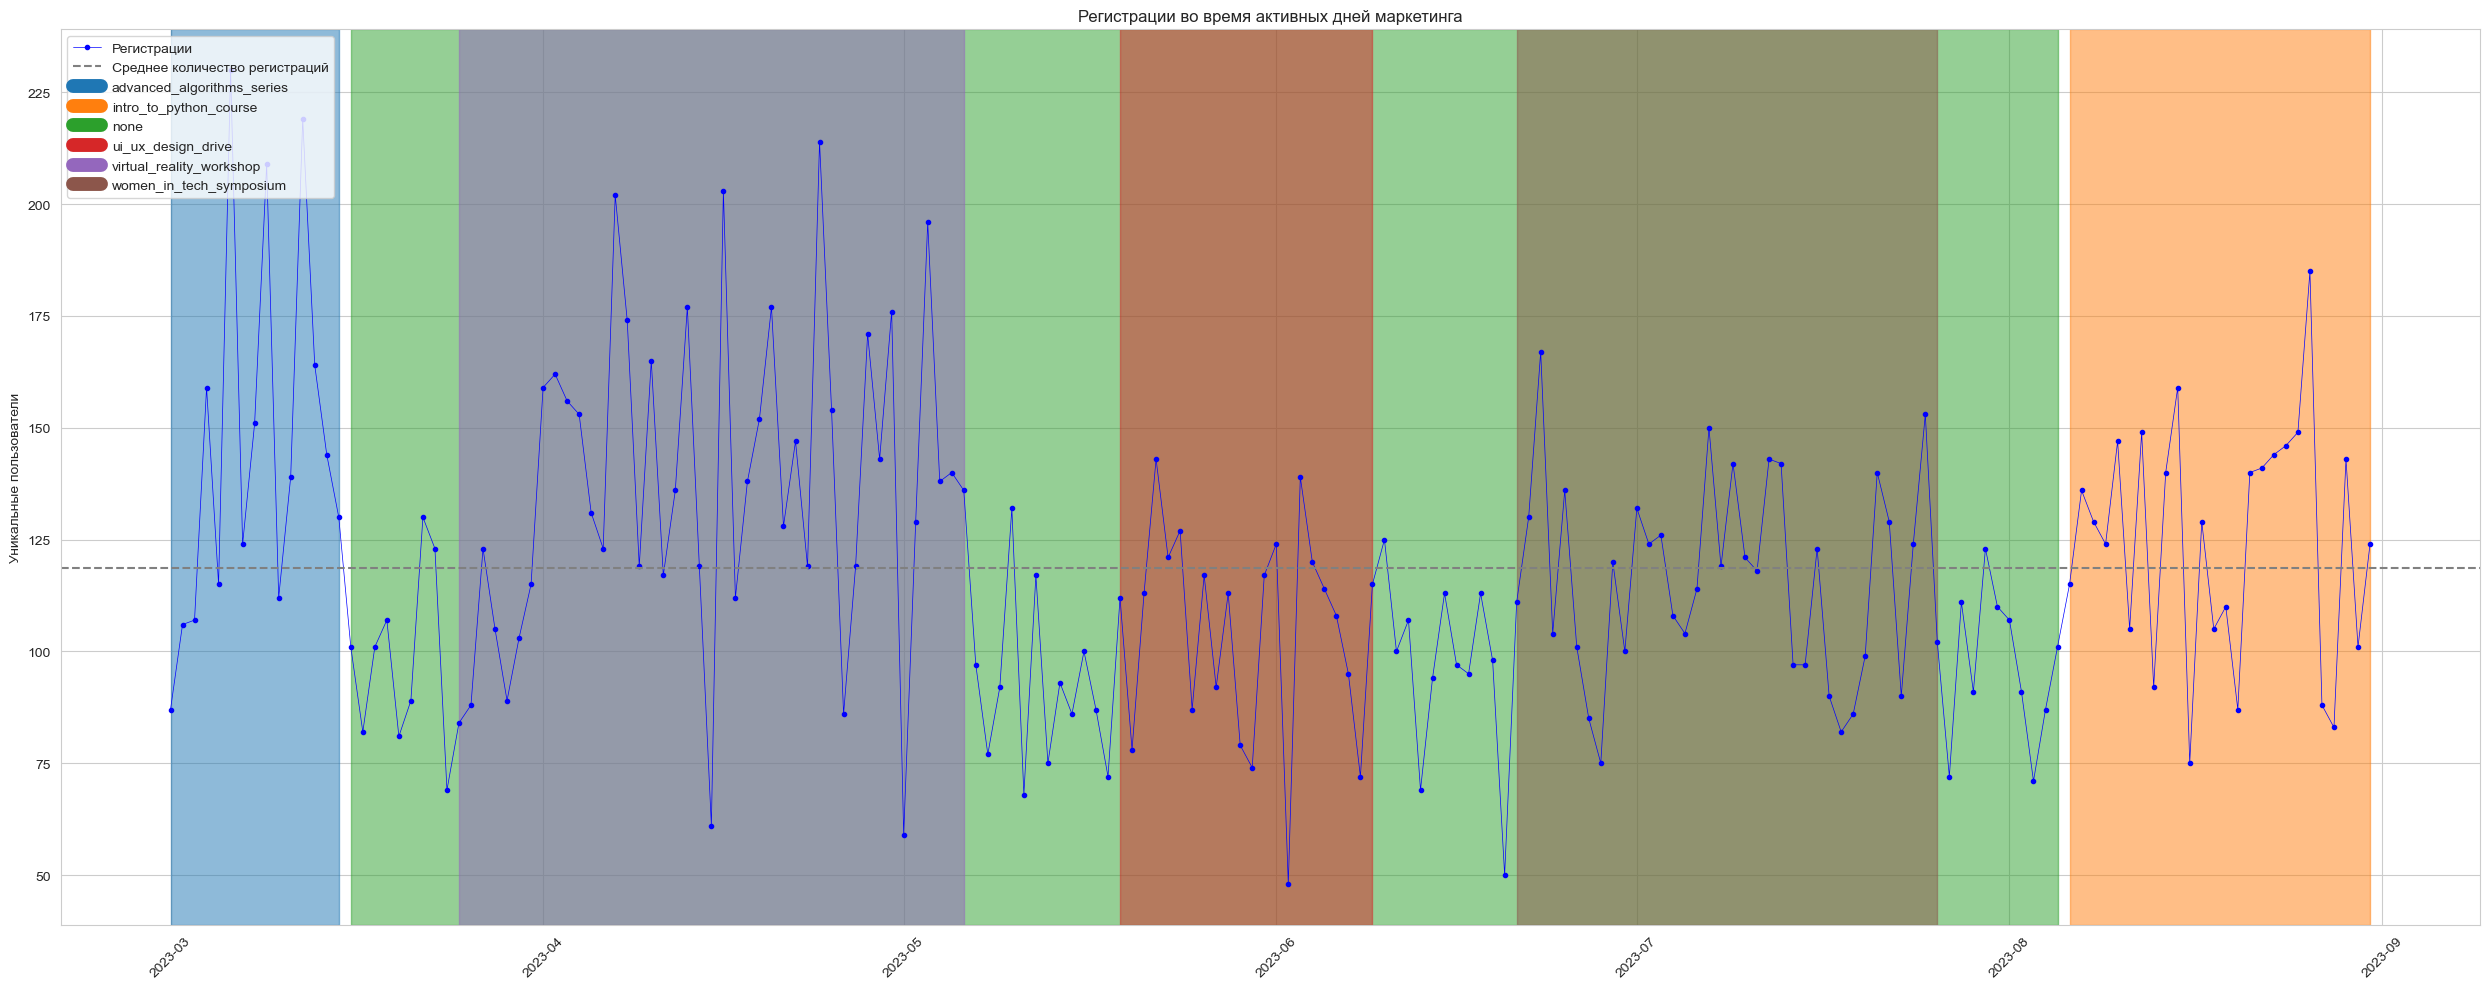

In [15]:
# Группировка данных по дате и рекламной кампании для подсчета суммарного количества регистраций
registrations_from_utm_campaign = final_ads_df.groupby(['date_group', 'utm_campaign']).agg({'registrations':'sum'}).reset_index()

# Создание фигуры для графика
plt.figure(figsize=(25, 10))
plt.title('Регистрации во время активных дней маркетинга')
plt.ylabel('Уникальные пользователи')
plt.xticks(rotation=45)

# Построение графика регистраций
plt.plot(registrations_from_utm_campaign['date_group'], registrations_from_utm_campaign['registrations'], color='blue', label='Регистрации',
         marker='o', linewidth=0.5, ms=3)

# Вывод среднего количества регистраций
plt.axhline(y=registrations_from_utm_campaign['registrations'].mean(), color='gray', linestyle='--', label="Среднее количество регистраций")

# Создание словаря цветов для каждой рекламной кампании
campaign_colors = dict(zip(ads_from_start_to_end['utm_campaign'].unique(), matplotlib.colors.TABLEAU_COLORS.values()))

# Выделение на графике периодов рекламных кампаний
for _, row in ads_from_start_to_end.iterrows():
    plt.axvspan(row['start'], row['end'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
    plt.plot([], [], color=campaign_colors[row['utm_campaign']], linewidth=10, label=row['utm_campaign'])

# Добавление легенды
plt.legend(loc='upper left')

# Сохранение графика в файл
plt.tight_layout()
plt.savefig('charts/Registrations during marketing active days.png')
plt.show()

Расчет корреляции между расходами на рекламу и конверсией

In [16]:
# Объединение данных о конверсии и расходах на рекламу по дате
merged_data = pd.merge(consolidated_data, final_ads_df, on='date_group', how='inner')

# Выберем только необходимые столбцы для расчета корреляции
correlation_matrix = merged_data[['conversion', 'cost']].corr()

# Вывод корреляционной матрицы
print(correlation_matrix)

            conversion      cost
conversion    1.000000 -0.059886
cost         -0.059886  1.000000


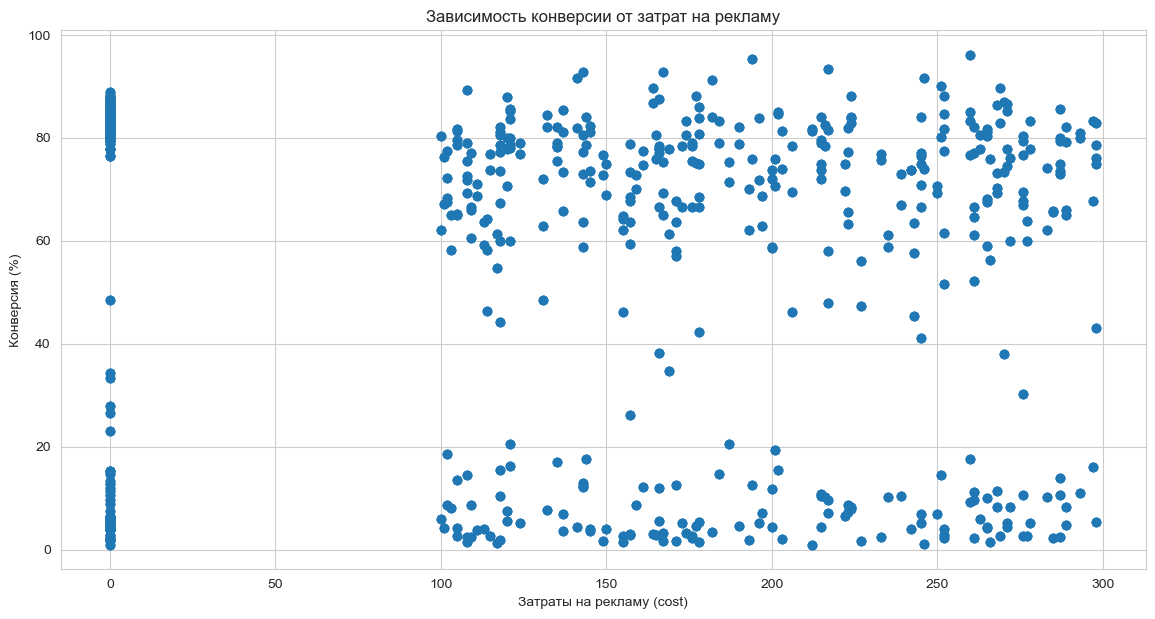

            conversion      cost
conversion    1.000000 -0.059886
cost         -0.059886  1.000000


In [17]:
# Объединение данных о конверсии и расходах на рекламу по дате
merged_data = pd.merge(consolidated_data, final_ads_df, on='date_group', how='inner')

# Выбор только необходимых столбцов для расчета корреляции: конверсия и стоимость
correlation_matrix = merged_data[['conversion', 'cost']].corr()

# Построение графика, показывающего зависимость регистраций от затрат на рекламу
# Использование scatter plot для визуализации корреляции
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.scatter(merged_data['cost'], merged_data['conversion'])
plt.title('Зависимость конверсии от затрат на рекламу')
plt.xlabel('Затраты на рекламу (cost)')
plt.ylabel('Конверсия (%)')
plt.grid(True)
plt.show()

# Вывод корреляционной матрицы
print(correlation_matrix)